In [ ]:
# ============================== IMPORT LIBRARIES ==============================
import os
import cv2
import numpy as np
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model



Num GPUs Available: 0
No GPU found! Training on CPU.
Loading Dataset...
Total Classes Detected: 43
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 
Data Imported Successfully.
Data Shapes
Train: (35837, 32, 32, 3), (35837,)
Validation: (15360, 32, 32, 3), (15360,)
Test: (21942, 32, 32, 3), (21942,)
Label Data Shape: (43, 2), Type: <class 'pandas.core.frame.DataFrame'>
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
          

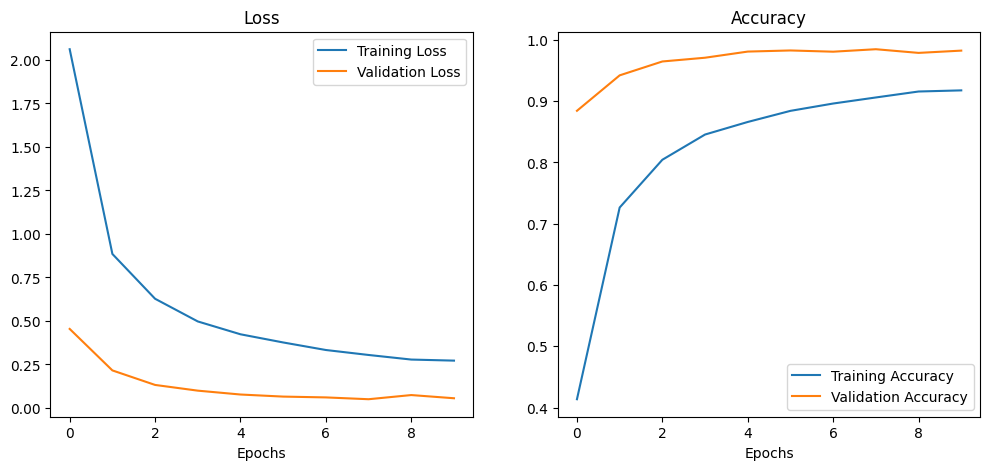

Test Score: 0.05441126972436905
Test Accuracy: 0.9834563732147217
Model Saved Successfully.


c:\Users\wator\Documents\Ananto\project\miniproject\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

# ============================== CONFIGURE GPU USAGE ==============================
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # ตั้งค่าให้ TensorFlow ใช้ GPU โดยไม่กิน RAM เกินจำเป็น
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is enabled!")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found! Training on CPU.")

# ============================== SET PARAMETERS ==============================
path = "Dataset"              # Path to dataset
labelFile = 'labels.csv'      # CSV file containing labels
batch_size_val = 32
epochs_val = 10
imageDimesions = (32, 32, 3)
testRatio = 0.3               # Test dataset ratio
validationRatio = 0.3         # Validation dataset ratio

# ============================== LOAD IMAGES & LABELS ==============================
print("Loading Dataset...")
images, classNo = [], []
myList = os.listdir(path)
noOfClasses = len(myList)
print(f"Total Classes Detected: {noOfClasses}")

for count, class_name in enumerate(myList):
    myPicList = os.listdir(os.path.join(path, str(count)))
    for img_name in myPicList:
        curImg = cv2.imread(os.path.join(path, str(count), img_name))
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
print("\nData Imported Successfully.")

# Convert lists to numpy arrays
images = np.array(images)
classNo = np.array(classNo)

# ============================== SPLIT DATASET ==============================
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

# Display dataset shapes
print("Data Shapes")
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_validation.shape}, {y_validation.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

# ============================== READ LABEL DATA ==============================
data = pd.read_csv(labelFile)
print(f"Label Data Shape: {data.shape}, Type: {type(data)}")

# ============================== IMAGE PREPROCESSING ==============================
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def equalize(img):
    return cv2.equalizeHist(img)

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255  # Normalize to range 0-1
    return img

# Apply preprocessing
X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

# Reshape for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# ============================== IMAGE DATA AUGMENTATION ==============================
dataGen = ImageDataGenerator(
    width_shift_range=0.1, height_shift_range=0.1,
    zoom_range=0.2, shear_range=0.1, rotation_range=10
)
dataGen.fit(X_train)

# ============================== CONVERT LABELS TO CATEGORICAL ==============================
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

# ============================== BUILD CNN MODEL ==============================
def myModel():
    model = Sequential()

    # Convolutional Layers
    model.add(Conv2D(64, (5,5), input_shape=(imageDimesions[0], imageDimesions[1], 1), activation='relu'))
    model.add(Conv2D(64, (5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ============================== TRAIN MODEL ==============================

model = myModel()
# Save Model Architecture
plot_model(model, to_file="/mnt/data/model_architecture.png", show_shapes=True, show_layer_names=True)

# Display Model Architecture
img = Image.open("/mnt/data/model_architecture.png")
print(model.summary())

history = model.fit(
    dataGen.flow(X_train, y_train, batch_size=batch_size_val),
    steps_per_epoch=len(X_train) // batch_size_val,
    epochs=epochs_val,
    validation_data=(X_validation, y_validation),
    shuffle=True
    )

# ============================== PLOT TRAINING HISTORY ==============================
plt.figure(figsize=(12,5))

# Loss Plot
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')

# Accuracy Plot
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')

plt.show()

# ============================== EVALUATE MODEL ==============================
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Score: {score[0]}")
print(f"Test Accuracy: {score[1]}")

# ============================== SAVE MODEL ==============================
model.save("model.h5")
print("Model Saved Successfully.")
